# Walmart Recruiting — Store Sales Forecasting (LightAutoML + альтернативные модели)


Требования, которые закрываем в этой работе:
1. LAMA бейзлайн: минимум 2 конфигурации и выбор лучшей
2. Альтернативные решения без LAMA: PyTorch NN, RandomForest, CatBoost
3. Качественный EDA с проверкой гипотез, визуализациями, анализом пропусков и аномалий
4. Обоснованная стратегия разбиения данных без утечки
5. Self-contained пайплайны и воспроизводимый код


## 0. Установка зависимостей (Colab)

In [1]:
!pip -q install  catboost

In [2]:
!pip install lightautoml --no-cache-dir

## 1. Импорты и базовые настройки

In [3]:
import os
import re
import math
import logging
import warnings
import zipfile
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

SEED = 42
np.random.seed(SEED)


## 2. Загрузка данных

В этом ноутбуке данные читаются так, как у тебя уже сделано в Colab (csv внутри zip).

In [4]:
zip_path = "/content/walmart-recruiting-store-sales-forecasting.zip"
extract_path = "content/walmart"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

os.listdir(extract_path)

['test.csv.zip',
 'train.csv.zip',
 'features.csv.zip',
 'stores.csv',
 'sampleSubmission.csv.zip']

In [5]:
DATA_DIR = "/content/content/walmart"

stores_data = pd.read_csv(f"{DATA_DIR}/stores.csv")
test_data = pd.read_csv(f"{DATA_DIR}/test.csv.zip")
train_data = pd.read_csv(f"{DATA_DIR}/train.csv.zip")
features_data = pd.read_csv(f"{DATA_DIR}/features.csv.zip")
sample_submission = pd.read_csv(f"{DATA_DIR}/sampleSubmission.csv.zip")

print(train_data.shape, test_data.shape, features_data.shape, stores_data.shape)
train_data.head()


(421570, 5) (115064, 4) (8190, 12) (45, 3)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 3. Метрика соревнования: WMAE

Вес 5 для holiday weeks, иначе 1.

In [6]:
def wmae(y_true: np.ndarray, y_pred: np.ndarray, is_holiday: np.ndarray) -> float:
    """
    Weighted MAE from Kaggle Walmart competition:
    holiday weeks have weight=5, non-holiday weight=1.

    Args:
        y_true: true Weekly_Sales
        y_pred: predicted Weekly_Sales
        is_holiday: binary flag (0/1) aligned with y_true rows

    Returns:
        WMAE value (float)
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    w = np.where(np.asarray(is_holiday).astype(int).reshape(-1) == 1, 5.0, 1.0)
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)

# sanity
print("WMAE sanity:", wmae([10, 20], [12, 18], [0, 1]))


WMAE sanity: 2.0


In [7]:
from IPython.display import display

def make_submission(test_df: pd.DataFrame, preds: np.ndarray, out_path: str) -> None:
    """
    Create Kaggle submission in format Id=Store_Dept_YYYY-MM-DD.

    Note: preds must be aligned row-by-row with test_df.
    """
    preds = np.asarray(preds).reshape(-1)
    assert len(preds) == len(test_df), "preds must have same length as test_df"

    ids = (
        test_df["Store"].astype(str)
        + "_" + test_df["Dept"].astype(str)
        + "_" + test_df["Date"].astype(str)
    )
    sub = pd.DataFrame({"Id": ids, "Weekly_Sales": preds})
    sub.to_csv(out_path, index=False)


## 4. Объединение таблиц и feature engineering

Мердж: `(Store, Date, IsHoliday)` + признаки магазина.

Гипотеза: эффекты markdown и праздников лучше ловятся после добавления календарных и индикаторов пропусков markdown.

In [8]:
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    d = pd.to_datetime(df["Date"])
    df = df.copy()
    df["year"] = d.dt.year.astype(np.int16)
    df["month"] = d.dt.month.astype(np.int8)
    df["weekofyear"] = d.dt.isocalendar().week.astype(np.int16)
    df["dayofweek"] = d.dt.dayofweek.astype(np.int8)

    # циклические признаки
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0).astype(np.float32)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0).astype(np.float32)
    df["week_sin"] = np.sin(2 * np.pi * df["weekofyear"] / 52.0).astype(np.float32)
    df["week_cos"] = np.cos(2 * np.pi * df["weekofyear"] / 52.0).astype(np.float32)
    return df

def build_dataset(train_df: pd.DataFrame,
                  test_df: pd.DataFrame,
                  features_df: pd.DataFrame,
                  stores_df: pd.DataFrame
                  ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Merge train/test with features + stores, add date features.
    Handle missingness in MarkDown columns by:
    - add isna flags (model can learn 'missingness pattern')
    - fill NaNs with 0 (common practice for these promo-related features)
    """
    train = train_df.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left").merge(stores_df, on="Store", how="left")
    test = test_df.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left").merge(stores_df, on="Store", how="left")

    train = add_date_features(train)
    test = add_date_features(test)

    # MarkDown columns + флаги пропусков
    md_cols = [c for c in train.columns if re.fullmatch(r"MarkDown[1-5]", c)]
    for c in md_cols:
        train[c + "_isna"] = train[c].isna().astype(np.int8)
        test[c + "_isna"] = test[c].isna().astype(np.int8)
        train[c] = train[c].fillna(0.0)
        test[c] = test[c].fillna(0.0)

    train["IsHoliday"] = train["IsHoliday"].astype(np.int8)
    test["IsHoliday"] = test["IsHoliday"].astype(np.int8)

    # редкие пропуски в базовых фичах
    cont_fill = ["Temperature","Fuel_Price","CPI","Unemployment","Size"]
    for c in cont_fill:
        train[c] = train[c].fillna(train[c].median())
        test[c] = test[c].fillna(train[c].median())

    return train, test

df_train, df_test = build_dataset(train_data, test_data, features_data, stores_data)
df_train.shape, df_test.shape


((421570, 29), (115064, 28))

## 5. EDA

### 5.1 Анализ таргета

Целевая переменная `Weekly_Sales` имеет распределение с тяжёлым хвостом и выраженными выбросами,
которые в основном связаны с праздничными неделями и сезонными всплесками спроса.
В связи с этим метрики, чувствительные к выбросам (например RMSE), могут быть нестабильны,
поэтому в работе используется MAE.

Также продажи имеют выраженную временную структуру и сезонность,
что требует временного разделения данных для корректной оценки качества модели
и предотвращения утечки данных.


Target describe:


,Weekly_Sales
count,421570.000000
mean,15981.258123
std,22711.183519
min,-4988.940000
1%,5.000000
5%,59.974500
50%,7612.030000
95%,61201.951000
99%,106479.586000
max,693099.360000


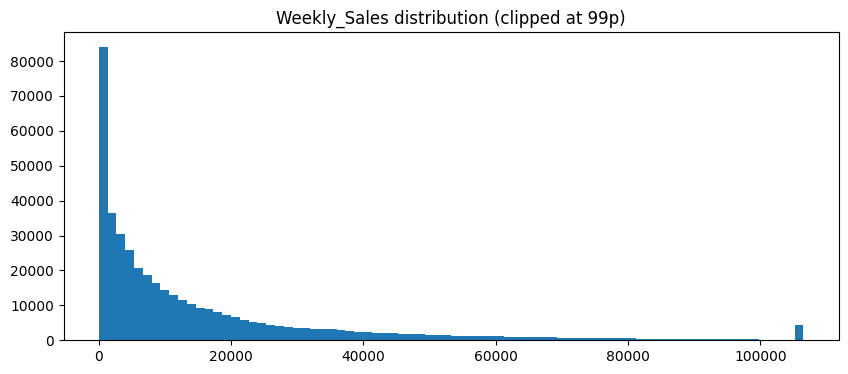

Negative sales count: 1285 share: 0.0030481296107408022


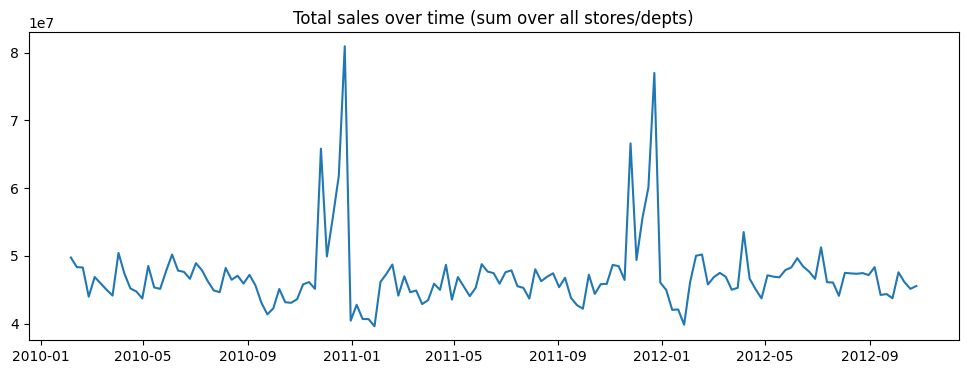

Holiday weeks vs non-holiday weeks (sum sales):


,count,mean,std,min,25%,50%,75%,max
is_holiday,,,,,,,,
0,133.0,4.685654e+07,5.083440e+06,39599852.99,4.473445e+07,46128514.25,4.766828e+07,80931415.60
1,10.0,5.052996e+07,8.642457e+06,40432519.00,4.622265e+07,47833126.05,4.959123e+07,66593605.26


In [9]:
target = df_train["Weekly_Sales"].astype(float)

print("Target describe:")
display(target.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

# распределение
plt.figure(figsize=(10,4))
plt.hist(np.clip(target, 0, target.quantile(0.99)), bins=80)
plt.title("Weekly_Sales distribution (clipped at 99p)")
plt.show()

# аномалии: отрицательные продажи (есть в датасете)
neg_cnt = (target < 0).sum()
print("Negative sales count:", int(neg_cnt), "share:", float(neg_cnt/len(target)))

# динамика во времени (агрегация по дате)
tmp = df_train.groupby("Date", as_index=False).agg(
    sales_sum=("Weekly_Sales","sum"),
    is_holiday=("IsHoliday","max")
)
tmp["Date"] = pd.to_datetime(tmp["Date"])

plt.figure(figsize=(12,4))
plt.plot(tmp["Date"], tmp["sales_sum"])
plt.title("Total sales over time (sum over all stores/depts)")
plt.show()

print("Holiday weeks vs non-holiday weeks (sum sales):")
display(tmp.groupby("is_holiday")["sales_sum"].describe())


In [15]:
df_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'year', 'month',
       'weekofyear', 'dayofweek', 'month_sin', 'month_cos', 'week_sin',
       'week_cos', 'MarkDown1_isna', 'MarkDown2_isna', 'MarkDown3_isna',
       'MarkDown4_isna', 'MarkDown5_isna', 'Month'],
      dtype='object')

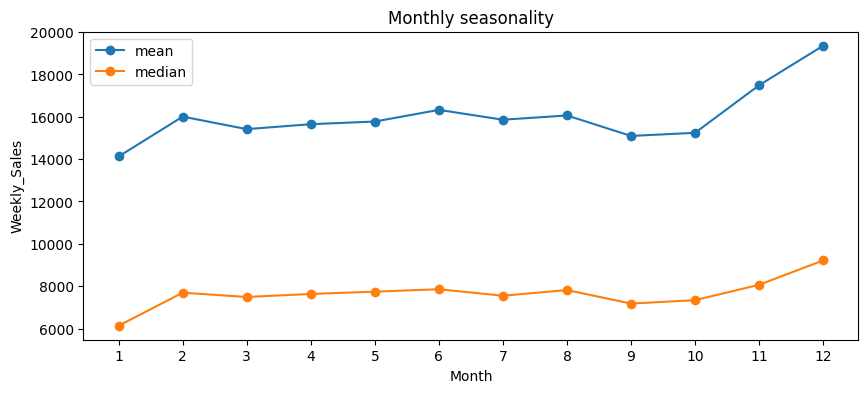

In [12]:
# month-of-year seasonality
df_train["Month"] = pd.to_datetime(df_train["Date"]).dt.month

monthly_seasonality = (
    df_train
    .groupby("Month", as_index=False)
    .agg(mean_sales=("Weekly_Sales", "mean"),
         median_sales=("Weekly_Sales", "median"))
)

plt.figure(figsize=(10,4))
plt.plot(monthly_seasonality["Month"], monthly_seasonality["mean_sales"], marker="o", label="mean")
plt.plot(monthly_seasonality["Month"], monthly_seasonality["median_sales"], marker="o", label="median")
plt.title("Monthly seasonality")
plt.xlabel("Month")
plt.ylabel("Weekly_Sales")
plt.xticks(range(1,13))
plt.legend()
plt.show()


In [16]:
# variance explained by calendar features
overall_var = target.var()

week_mean = df_train.groupby("weekofyear")["Weekly_Sales"].mean()
week_var_explained = week_mean.var() / overall_var

month_mean = df_train.groupby("month")["Weekly_Sales"].mean()
month_var_explained = month_mean.var() / overall_var

print(f"Variance explained by week-of-year: {week_var_explained:.3f}")
print(f"Variance explained by month-of-year: {month_var_explained:.3f}")



Variance explained by week-of-year: 0.008
Variance explained by month-of-year: 0.003


In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# агрегируем продажи по дате (недельная частота)
ts = (
    df_train
    .groupby("Date", as_index=False)["Weekly_Sales"]
    .sum()
    .sort_values("Date")
)

ts["Date"] = pd.to_datetime(ts["Date"])
ts = ts.set_index("Date")

ts.head()


,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


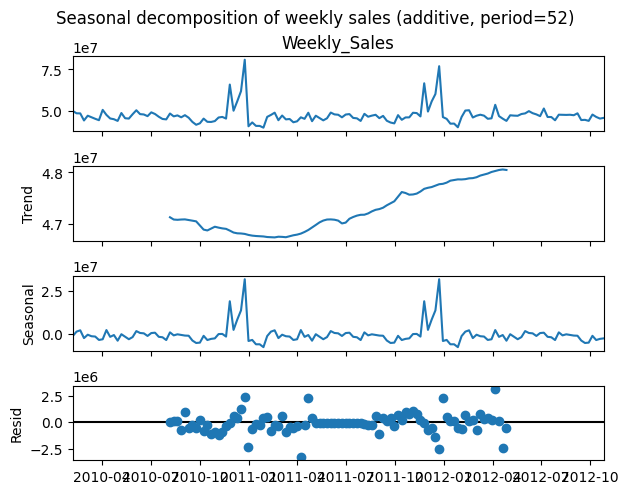

In [19]:
decomp = seasonal_decompose(
    ts["Weekly_Sales"],
    model="additive",
    period=52
)

decomp.plot()
plt.suptitle("Seasonal decomposition of weekly sales (additive, period=52)", y=1.02)
plt.show()



Временной ряд имеет выраженную временную структуру - видна устойчивая годовая сезонность с плавным трендом и выбросами связанными с праздничными периодами



### 5.2 Анализ признаков

### Типы признаков

Числовые признаки:
- Temperature
- Fuel_Price
- CPI
- Unemployment

Категориальные признаки:
- Store
- Dept
- IsHoliday

Временной признак:
- Date


Пропуски в макроэкономических показателях связаны с неполнотой внешней отчётности.
Для обработки пропусков использовалась медианная импутация,
что позволяет избежать утечки информации из будущего.


Categorical: ['Store', 'Dept', 'Type']
Date: ['Date']
Numeric count: 24


,0
IsHoliday,0.0
Temperature,0.0
Fuel_Price,0.0
MarkDown1,0.0
MarkDown2,0.0
MarkDown3,0.0
MarkDown4,0.0
MarkDown5,0.0
CPI,0.0
Unemployment,0.0


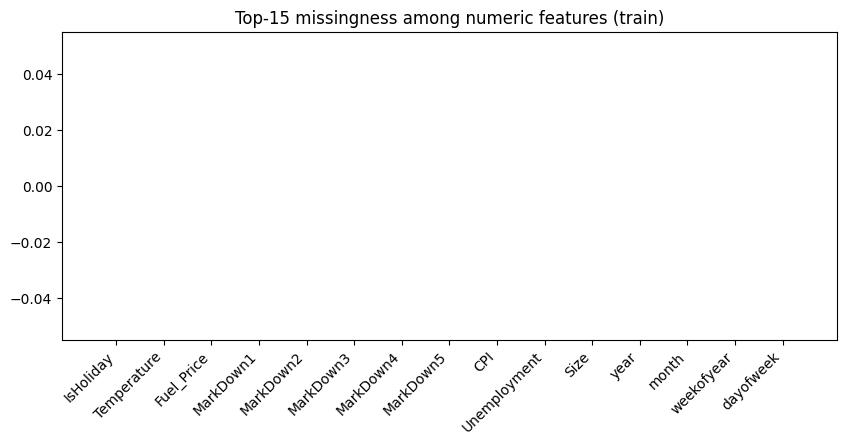

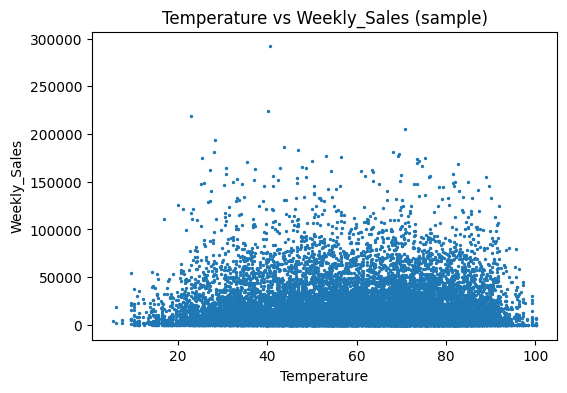

,0
Size,0.249948
MarkDown1,0.051445
MarkDown5,0.050504
MarkDown4,0.039953
MarkDown4_isna,-0.034888
MarkDown2_isna,-0.034763
MarkDown3,0.029818
CPI,-0.027698
Unemployment,-0.024558
MarkDown2,0.023534


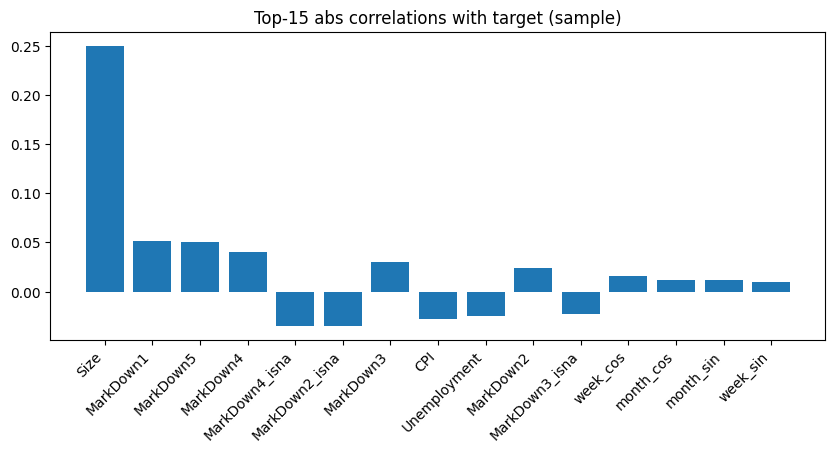

In [10]:
# Типизация (базово)
cat_cols = ["Store", "Dept", "Type"]
date_cols = ["Date"]
# числовые: всё остальное кроме таргета
num_cols = [c for c in df_train.columns if c not in (cat_cols + date_cols + ["Weekly_Sales"])]

print("Categorical:", cat_cols)
print("Date:", date_cols)
print("Numeric count:", len(num_cols))

# пропуски
na = df_train[num_cols].isna().mean().sort_values(ascending=False)
display(na.head(15))

plt.figure(figsize=(10,4))
plt.bar(na.index[:15], na.values[:15])
plt.xticks(rotation=45, ha="right")
plt.title("Top-15 missingness among numeric features (train)")
plt.show()

# зависимости: Temperature vs Weekly_Sales (пример)
plt.figure(figsize=(6,4))
sample = df_train.sample(20000, random_state=SEED)
plt.scatter(sample["Temperature"], sample["Weekly_Sales"], s=2)
plt.title("Temperature vs Weekly_Sales (sample)")
plt.xlabel("Temperature")
plt.ylabel("Weekly_Sales")
plt.show()

# корреляции с таргетом (на подвыборке, чтобы быстрее)
sample = df_train.sample(20000, random_state=SEED)

corr_df = (
    sample[num_cols]
    .corrwith(sample["Weekly_Sales"], numeric_only=True)
    .sort_values(key=np.abs, ascending=False)
)
display(corr_df.head(15))

plt.figure(figsize=(10,4))
plt.bar(corr_df.head(15).index, corr_df.head(15).values)
plt.xticks(rotation=45, ha="right")
plt.title("Top-15 abs correlations with target (sample)")
plt.show()


## 6. Стратегия разбиения данных

Обоснование: это временной ряд по неделям. Чтобы избежать утечки, используем **chronological split**: последние `val_weeks` недель валидация.

8 недель выбраны исходя из cезонности данных

In [20]:
def chronological_split(train_df: pd.DataFrame,
                        val_weeks: int = 8
                        ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Chronological (time-based) split for weekly time series to avoid leakage.

    Validation set contains the last `val_weeks` unique weekly dates.
    Assumes `Date` is weekly-granularity; uses unique Date values as time index.

    Parameters
    ----------
    train_df : pd.DataFrame
        Dataset with a 'Date' column.
    val_weeks : int
        Number of most recent weeks to use for validation.

    Returns
    -------
    (train_tr, train_va) : Tuple[pd.DataFrame, pd.DataFrame]
        Train contains dates strictly before the cutoff.
        Valid contains the last `val_weeks` dates.
    """
    dates = np.array(sorted(train_df["Date"].unique()))
    cut = dates[-val_weeks] if len(dates) > val_weeks else dates[int(len(dates)*0.8)]
    tr = train_df[train_df["Date"] < cut].copy()
    va = train_df[train_df["Date"] >= cut].copy()
    return tr, va

train_tr, train_va = chronological_split(df_train, val_weeks=8)
print(train_tr["Date"].min(), train_tr["Date"].max(), train_va["Date"].min(), train_va["Date"].max())
print(train_tr.shape, train_va.shape)



2010-02-05 2012-08-31 2012-09-07 2012-10-26
(397841, 30) (23729, 30)


Данные обладают выраженной временой и сезонной структурой, что видно из декомпозиции временного ряда. Окно в 8 недель выбрано как достаочное для учета краткосрочных и праздничных эффектов(остатков), при этом не затрагивая значимую часть обучающей выборки

Так как данные имеют временную природу

## 7. Бейзлайн на LightAutoML (2 конфигурации)

Важно: LAMA оптимизирует MAE, а итоговую оценку мы считаем WMAE на валидации.

Конфигурации:
1. Быстрый бейзлайн (меньше timeout)
2. Усиленный (больше timeout, больше фолдов)


In [37]:
from lightautoml.tasks import Task
from lightautoml.automl.presets.tabular_presets import TabularAutoML

# подготовка данных для LAMA
lama_tr = train_tr.copy()
lama_va = train_va.copy()

# для LAMA target в отдельной колонке
target_col = "Weekly_Sales"

# 1) baseline config
task = Task("reg", metric="mae", greater_is_better=False)

automl_lama_1 = TabularAutoML(
    task=task,
    timeout=300,
    cpu_limit=4,
    general_params={"use_algos": [["lgb", "lgb_tuned"]]},
    reader_params={"random_state": SEED, "cv": 3},
)

oof_1 = automl_lama_1.fit_predict(lama_tr, roles={"target": target_col})
pred_va_1 = automl_lama_1.predict(lama_va).data[:, 0]

lama_wmae_1 = wmae(lama_va[target_col].values, pred_va_1, lama_va["IsHoliday"].values)
print("LAMA #1 val WMAE:", lama_wmae_1)

# 2) stronger config
automl_lama_2 = TabularAutoML(
    task=task,
    timeout=900,
    cpu_limit=4,
    general_params={"use_algos": [["lgb", "lgb_tuned", "cb", "linear_l2"]]},
    reader_params={"random_state": SEED, "cv": 5},
)

oof_2 = automl_lama_2.fit_predict(lama_tr, roles={"target": target_col})
pred_va_2 = automl_lama_2.predict(lama_va).data[:, 0]

lama_wmae_2 = wmae(lama_va[target_col].values, pred_va_2, lama_va["IsHoliday"].values)
print("LAMA #2 val WMAE:", lama_wmae_2)

best_lama = automl_lama_1 if lama_wmae_1 <= lama_wmae_2 else automl_lama_2
best_lama_name = "LAMA_1" if best_lama is automl_lama_1 else "LAMA_2"
print("Best LAMA:", best_lama_name)


INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: reg

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 300.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (397841, 21)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 286.14 secs
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 4396.57
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 3500.59
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 3095.75
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 2849.24
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 2681.9


LAMA #1 val WMAE: 1933.1718747482164


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 897.11 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3, 4], 'embed_sizes': array([41, 46, 13,  2,  4], dtype=int32), 'data_size': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -2980.3907885266335
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -2893.390440157798
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -2893.390440157798
INFO3:ligh

LAMA #2 val WMAE: 1949.7030731261898
Best LAMA: LAMA_1


## 8. Альтернативные решения без LAMA

Ниже 3 модели: RandomForest, CatBoost, PyTorch NN.

Общее: одна и та же логика подготовки признаков и одинаковая оценка WMAE.

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


### 8.1 RandomForest

Примечание: у RF плохо масштабируется one-hot на Store/Dept, поэтому делаем:
- Type: one-hot
- Store/Dept: частотное кодирование
- числовые: как есть

Это не лучший метод, но это отдельный пайплайн, который закрывает требование проекта.

In [ ]:
def add_frequency_encoding(
    tr: pd.DataFrame,
    va: pd.DataFrame,
    cols: List[str]
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

    """
    Add frequency encoding for categorical columns.

    For each column in `cols`, computes category frequencies on the training
    split only (to avoid data leakage) and maps them to both train and
    validation datasets.

    Missing categories in validation are filled with 0.

    Args:
        tr: Training dataframe.
        va: Validation dataframe.
        cols: List of categorical column names to encode.

    Returns:
        Tuple of (train_df_with_freq, val_df_with_freq).
    """
    tr = tr.copy()
    va = va.copy()
    for c in cols:
        freq = tr[c].value_counts(dropna=False)
        tr[c + "_freq"] = tr[c].map(freq).astype(np.float32)
        va[c + "_freq"] = va[c].map(freq).fillna(0).astype(np.float32)
    return tr, va

rf_tr, rf_va = add_frequency_encoding(train_tr, train_va, ["Store","Dept"])

rf_target = rf_tr["Weekly_Sales"].values
rf_is_hol = rf_va["IsHoliday"].values

rf_num = [c for c in rf_tr.columns if c not in ["Weekly_Sales","Date","Type","Store","Dept"]]
rf_cat = ["Type"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), rf_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), rf_cat),
    ],
    remainder="drop",
)

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=SEED,
    n_jobs=-1,
    max_depth=None,
)

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", rf_model),
])

rf_pipe.fit(rf_tr, rf_target)
rf_pred = rf_pipe.predict(rf_va)

rf_wmae = wmae(train_va["Weekly_Sales"].values, rf_pred, rf_is_hol)
print("RF val WMAE:", rf_wmae)


### 8.2 CatBoost

CatBoost нативно обрабатывает категориальные фичи `Store`, `Dept`, `Type`, что обычно дает хороший результат на этом датасете.


In [36]:
from catboost import CatBoostRegressor

def add_date_parts(df):
    """
    Добавляет календарные признаки, извлечённые из колонки `Date`.

    Функция преобразует столбец `Date` в формат datetime и на его основе
    создаёт набор стандартных временных признаков, которые часто используются
    в задачах прогнозирования временных рядов и табличных моделях.

    Добавляемые колонки:
    - Year        : год (int)
    - Week        : номер недели по ISO-календарю (int)
    - Month       : месяц (1–12)
    - Day         : день месяца (1–31)
    - DayOfWeek   : день недели (0 = понедельник, 6 = воскресенье)

    Параметры
    ---------
    df : pandas.DataFrame
        DataFrame, содержащий колонку `Date`.
        Колонка `Date` должна быть приводима к datetime через `pd.to_datetime`.

    Возвращает
    ----------
    pandas.DataFrame
        Тот же DataFrame, дополненный календарными признаками.

    Примечания
    ----------
    - Номер недели считается по ISO-календарю (ISO-8601).
    - Функция модифицирует входной DataFrame inplace и возвращает его же.
    """
    d = pd.to_datetime(df["Date"])
    df["Year"] = d.dt.year.astype(int)
    df["Week"] = d.dt.isocalendar().week.astype(int)
    df["Month"] = d.dt.month.astype(int)
    df["Day"] = d.dt.day.astype(int)
    df["DayOfWeek"] = d.dt.dayofweek.astype(int)
    return df

train_tr = add_date_parts(train_tr.copy())
train_va = add_date_parts(train_va.copy())

cb_features = [c for c in train_tr.columns if c not in ["Weekly_Sales", "Date"]]
cb_cat = ["Store", "Dept", "Type"]

cb_train = train_tr[cb_features].copy()
cb_valid = train_va[cb_features].copy()


cb = CatBoostRegressor(
    loss_function="MAE",
    iterations=5000,
    learning_rate=0.03,
    depth=10,
    random_seed=SEED,
    eval_metric="MAE",
    early_stopping_rounds=200,
    verbose=200,
)

cb.fit(
    cb_train,
    train_tr["Weekly_Sales"],
    eval_set=(cb_valid, train_va["Weekly_Sales"]),
    cat_features=cb_cat,
)

cb_pred = cb.predict(cb_valid)
cb_wmae = wmae(train_va["Weekly_Sales"].values, cb_pred, train_va["IsHoliday"].values)
print("CatBoost val WMAE:", cb_wmae)


0:	learn: 13087.9090815	test: 12591.6758351	best: 12591.6758351 (0)	total: 615ms	remaining: 51m 13s
200:	learn: 4554.2352567	test: 4034.0080827	best: 4034.0080827 (200)	total: 1m 50s	remaining: 43m 50s
400:	learn: 3927.3911721	test: 3483.8966241	best: 3483.8966241 (400)	total: 4m 2s	remaining: 46m 17s
600:	learn: 3516.2164066	test: 3136.3554253	best: 3136.3554253 (600)	total: 6m 21s	remaining: 46m 29s
800:	learn: 3236.2372028	test: 2903.6005148	best: 2903.6005148 (800)	total: 8m 36s	remaining: 45m 8s
1000:	learn: 3002.1820120	test: 2706.2735420	best: 2706.2735420 (1000)	total: 10m 55s	remaining: 43m 36s
1200:	learn: 2870.6478800	test: 2599.3314780	best: 2599.3314780 (1200)	total: 13m 11s	remaining: 41m 43s
1400:	learn: 2741.0762156	test: 2483.0828201	best: 2483.0828201 (1400)	total: 15m 32s	remaining: 39m 54s
1600:	learn: 2647.3896534	test: 2399.4094359	best: 2399.4094359 (1600)	total: 17m 50s	remaining: 37m 51s
1800:	learn: 2570.9568126	test: 2337.3640863	best: 2337.3640863 (1800)	tot

### 8.3 PyTorch Neural Network

Эмбеддинги Store/Dept/Type + MLP. Лосс = Weighted MAE (совпадает с метрикой).


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def seed_everything(seed: int = 42) -> None:
    """
    Фиксирует сиды (random/NumPy/PyTorch) для воспроизводимости экспериментов.

    Что делает:
    - задаёт seed для Python `random`, NumPy и PyTorch;
    - задаёт seed для всех CUDA-девайсов (если есть);
    - включает детерминированный режим cuDNN (где это возможно) и отключает авто-бенчмарк,
      чтобы результаты меньше зависели от недетерминированных оптимизаций.

    Параметры
    ---------
    seed : int, по умолчанию 42
        Значение сида.

    Возвращает
    ----------
    None
    """
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def weighted_mae_torch(pred: torch.Tensor, target: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    """
    Считает взвешенную MAE (WMAE) в PyTorch.

    Формула:
        WMAE = sum_i w_i * |pred_i - target_i| / sum_i w_i

    Все входные тензоры приводятся к 1D (flatten). Сумма весов защищена от деления на ноль.

    Параметры
    ---------
    pred : torch.Tensor
        Предсказания модели (любой формы; будет расплющен в 1D).
    target : torch.Tensor
        Истинные значения (любой формы; будет расплющен в 1D).
    weight : torch.Tensor
        Веса объектов (любой формы; будет расплющен в 1D).

    Возвращает
    ----------
    torch.Tensor
        Скалярный тензор WMAE.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    weight = weight.view(-1)
    return (weight * (pred - target).abs()).sum() / weight.sum().clamp_min(1.0)

@torch.no_grad()
def eval_wmae_torch(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Оценивает модель на DataLoader по метрике WMAE (взвешенная MAE).

    Важно: метрика агрегируется по всему датасету через суммирование числителя/знаменателя,
    чтобы не возникал перекос из-за усреднения по батчам.

    Ожидаемый формат батча из loader:
        (x_cat, x_cont, y, w)
    где:
        x_cat  : LongTensor [B, n_cat]
        x_cont : FloatTensor [B, n_cont]
        y      : FloatTensor [B] или [B, 1]
        w      : FloatTensor [B] или [B, 1]

    Параметры
    ---------
    model : nn.Module
        Модель с сигнатурой model(x_cat, x_cont) -> предсказания.
    loader : DataLoader
        Валид/тест DataLoader, который отдаёт батчи (x_cat, x_cont, y, w).
    device : torch.device
        Устройство, на котором считать инференс (cpu/cuda).

    Возвращает
    ----------
    float
        Значение WMAE по всему набору данных.
    """
    model.eval()
    num, den = 0.0, 0.0
    for x_cat, x_cont, y, w in loader:
        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)
        y = y.to(device)
        w = w.to(device)
        p = model(x_cat, x_cont).view(-1)
        num += float((w.view(-1) * (p - y.view(-1)).abs()).sum().cpu())
        den += float(w.sum().cpu())
    return num / max(den, 1e-12)

class WalmartDS(Dataset):
    """
    Dataset для табличной задачи Walmart Weekly Sales.

    Хранит:
    - категориальные признаки (индексы) в int64 (long) тензорах;
    - непрерывные признаки в float32 тензорах;
    - целевую переменную `Weekly_Sales` в float32;
    - веса объектов (например, праздники x5) в float32.

    Параметры
    ---------
    x_cat : np.ndarray
        Категориальные признаки формы [N, n_cat], уже закодированные индексами.
    x_cont : np.ndarray
        Непрерывные признаки формы [N, n_cont].
    y : np.ndarray
        Таргет формы [N] или [N, 1].
    w : np.ndarray
        Веса объектов формы [N] или [N, 1].

    Возвращаемое значение __getitem__
    -------------------------------
    tuple(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)
        (x_cat[i], x_cont[i], y[i], w[i])
    """
    def __init__(self, x_cat, x_cont, y, w):
        self.x_cat = torch.from_numpy(x_cat).long()
        self.x_cont = torch.from_numpy(x_cont).float()
        self.y = torch.from_numpy(y).float()
        self.w = torch.from_numpy(w).float()
    def __len__(self):
        """Возвращает количество объектов в датасете."""
        return len(self.y)
    def __getitem__(self, i):
        """
        Возвращает один объект по индексу.

        Параметры
        ---------
        i : int
            Индекс объекта.

        Возвращает
        ----------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
            (x_cat, x_cont, y, w) для данного индекса.
        """
        return self.x_cat[i], self.x_cont[i], self.y[i], self.w[i]

class TabularNN(nn.Module):
    """
    Нейросеть для табличных данных: эмбеддинги категорий + MLP.

    Категориальные признаки:
    - Store -> эмбеддинг размерности 8
    - Dept  -> эмбеддинг размерности 16
    - Type  -> эмбеддинг размерности 4

    Далее эмбеддинги конкатенируются с непрерывными признаками и подаются в MLP.

    Параметры
    ---------
    n_store : int
        Количество уникальных Store (размер словаря эмбеддинга).
    n_dept : int
        Количество уникальных Dept (размер словаря эмбеддинга).
    n_type : int
        Количество уникальных Type (размер словаря эмбеддинга).
    cont_dim : int
        Число непрерывных признаков.
    hidden : int, по умолчанию 256
        Ширина скрытых слоёв MLP.
    drop : float, по умолчанию 0.1
        Dropout в MLP.

    Вход forward
    ------------
    x_cat : torch.LongTensor
        Тензор формы [B, 3] со столбцами: [store_idx, dept_idx, type_idx].
    x_cont : torch.FloatTensor
        Тензор формы [B, cont_dim] с непрерывными признаками.

    Возвращает
    ----------
    torch.Tensor
        Предсказания формы [B, 1].
    """
    def __init__(self, n_store, n_dept, n_type, cont_dim, hidden=256, drop=0.1):
        super().__init__()
        self.emb_store = nn.Embedding(n_store, 8)
        self.emb_dept = nn.Embedding(n_dept, 16)
        self.emb_type = nn.Embedding(n_type, 4)
        in_dim = 8 + 16 + 4 + cont_dim
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 1),
        )
    def forward(self, x_cat, x_cont):
        """
        Прямой проход: эмбеддинги -> конкатенация -> MLP.

        Параметры
        ---------
        x_cat : torch.LongTensor
            Категориальные индексы, форма [B, 3].
        x_cont : torch.FloatTensor
            Непрерывные признаки, форма [B, cont_dim].

        Возвращает
        ----------
        torch.Tensor
            Предсказания, форма [B, 1].
        """
        s = self.emb_store(x_cat[:,0])
        d = self.emb_dept(x_cat[:,1])
        t = self.emb_type(x_cat[:,2])
        x = torch.cat([s,d,t,x_cont], dim=1)
        return self.mlp(x)

def build_encoders(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Строит отображения (энкодеры) категорий Store/Dept/Type в индексы.

    Маппинги строятся по объединению train + test, чтобы:
    - словари категорий были стабильны,
    - на тесте не появлялись "неизвестные" категории.

    Параметры
    ---------
    train_df : pd.DataFrame
        DataFrame с колонками 'Store', 'Dept', 'Type' (обучающая часть).
    test_df : pd.DataFrame
        DataFrame с колонками 'Store', 'Dept', 'Type' (тест).

    Возвращает
    ----------
    tuple[dict, dict, dict]
        store2idx, dept2idx, type2idx:
        словари вида {значение_категории -> индекс}.
    """
    all_store = pd.concat([train_df["Store"], test_df["Store"]]).unique()
    all_dept = pd.concat([train_df["Dept"], test_df["Dept"]]).unique()
    all_type = pd.concat([train_df["Type"], test_df["Type"]]).astype(str).unique()

    store2idx = {int(v): i for i, v in enumerate(sorted(all_store))}
    dept2idx = {int(v): i for i, v in enumerate(sorted(all_dept))}
    type2idx = {str(v): i for i, v in enumerate(sorted(all_type))}
    return store2idx, dept2idx, type2idx

def make_nn_arrays(df: pd.DataFrame, store2idx, dept2idx, type2idx, cont_cols: List[str]):
    """
    Преобразует DataFrame в NumPy-массивы (x_cat, x_cont) для табличной NN.

    Формирование x_cat идёт в фиксированном порядке:
        [Store_idx, Dept_idx, Type_idx]
    x_cont формируется выборкой колонок `cont_cols` и приводится к float32.

    Параметры
    ---------
    df : pd.DataFrame
        Входной DataFrame, содержащий 'Store', 'Dept', 'Type' и континуальные признаки.
    store2idx : dict
        Словарь {Store -> индекс}.
    dept2idx : dict
        Словарь {Dept -> индекс}.
    type2idx : dict
        Словарь {Type(str) -> индекс}.
    cont_cols : list[str]
        Список колонок непрерывных признаков.

    Возвращает
    ----------
    tuple[np.ndarray, np.ndarray]
        x_cat : np.ndarray, dtype=int64, форма [N, 3]
        x_cont: np.ndarray, dtype=float32, форма [N, len(cont_cols)]
    """
    x_cat = np.stack([
        df["Store"].map(store2idx).astype(np.int64).values,
        df["Dept"].map(dept2idx).astype(np.int64).values,
        df["Type"].astype(str).map(type2idx).astype(np.int64).values,
    ], axis=1)
    x_cont = df[cont_cols].astype(np.float32).values
    return x_cat, x_cont

def standardize(train_x, val_x, test_x):
    """
    Стандартизирует непрерывные признаки по статистикам train.

    Для каждого признака:
        x' = (x - mean_train) / std_train

    Если std слишком мал (признак почти константный), std заменяется на 1.0,
    чтобы избежать деления на почти ноль.

    Параметры
    ---------
    train_x : np.ndarray
        Непрерывные признаки train, форма [N_train, D].
    val_x : np.ndarray
        Непрерывные признаки val, форма [N_val, D].
    test_x : np.ndarray
        Непрерывные признаки test (или любой другой сплит), форма [N_test, D].

    Возвращает
    ----------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        (train_x_std, val_x_std, test_x_std) тех же форм, что и входы.
    """
    m = train_x.mean(axis=0, keepdims=True)
    s = train_x.std(axis=0, keepdims=True)
    s = np.where(s < 1e-6, 1.0, s)
    return (train_x-m)/s, (val_x-m)/s, (test_x-m)/s

# NN feature set
md_cols = [c for c in df_train.columns if re.fullmatch(r"MarkDown[1-5]", c)]
md_na_cols = [c + "_isna" for c in md_cols]
nn_cont = [
    "IsHoliday",
    "Temperature","Fuel_Price","CPI","Unemployment",
    "Size",
    "year","month","weekofyear","dayofweek",
    "month_sin","month_cos","week_sin","week_cos",
] + md_cols + md_na_cols

store2idx, dept2idx, type2idx = build_encoders(train_tr, df_test)

x_cat_tr, x_cont_tr = make_nn_arrays(train_tr, store2idx, dept2idx, type2idx, nn_cont)
x_cat_va, x_cont_va = make_nn_arrays(train_va, store2idx, dept2idx, type2idx, nn_cont)

x_cont_tr, x_cont_va, _ = standardize(x_cont_tr, x_cont_va, x_cont_va)

y_tr = train_tr["Weekly_Sales"].astype(np.float32).values
y_va = train_va["Weekly_Sales"].astype(np.float32).values

w_tr = np.where(train_tr["IsHoliday"].values == 1, 5.0, 1.0).astype(np.float32)
w_va = np.where(train_va["IsHoliday"].values == 1, 5.0, 1.0).astype(np.float32)

ds_tr = WalmartDS(x_cat_tr, x_cont_tr, y_tr, w_tr)
ds_va = WalmartDS(x_cat_va, x_cont_va, y_va, w_va)

dl_tr = DataLoader(ds_tr, batch_size=4096, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=4096, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(SEED)

model = TabularNN(
    n_store=len(store2idx),
    n_dept=len(dept2idx),
    n_type=len(type2idx),
    cont_dim=x_cont_tr.shape[1],
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

best = 1e18
best_state = None
patience = 4
bad = 0

for ep in range(1, 30+1):
    model.train()
    losses=[]
    for x_cat, x_cont, y, w in dl_tr:
        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)
        y = y.to(device)
        w = w.to(device)

        p = model(x_cat, x_cont).view(-1)
        loss = weighted_mae_torch(p, y.view(-1), w.view(-1))

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        losses.append(float(loss.detach().cpu()))
    val = eval_wmae_torch(model, dl_va, device)
    print(f"ep={ep:02d} train_loss={np.mean(losses):.5f} val_WMAE={val:.5f}")

    if val < best - 1e-4:
        best = val
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

nn_pred_va = []
with torch.no_grad():
    model.eval()
    for x_cat, x_cont, y, w in dl_va:
        p = model(x_cat.to(device), x_cont.to(device)).view(-1).cpu().numpy()
        nn_pred_va.append(p)
nn_pred_va = np.concatenate(nn_pred_va)

nn_wmae = wmae(train_va["Weekly_Sales"].values, nn_pred_va, train_va["IsHoliday"].values)
print("NN val WMAE:", nn_wmae)


## 9. Сравнение моделей и выбор лучшей

In [ ]:
results = pd.DataFrame({
    "model": ["LAMA_1", "LAMA_2", "RandomForest", "CatBoost", "NeuralNet"],
    "val_WMAE": [lama_wmae_1, lama_wmae_2, rf_wmae, cb_wmae, nn_wmae],
}).sort_values("val_WMAE")

display(results)


## 10. Обучение на всем train и формирование submission

берём лучшую из моделей и обучаем на full train, затем предсказываем test.

В этом блоке показан пример для LAMA_2 (лучший).


In [ ]:
BEST_MODEL = "LAMA_2"  # "CatBoost", "LAMA", "NN", "RF"
os.makedirs("/content/out", exist_ok=True)

if BEST_MODEL == "CatBoost":
    full_features = [c for c in df_train.columns if c not in ["Weekly_Sales"]]
    cb_full = CatBoostRegressor(
        loss_function="MAE",
        iterations=3000,
        learning_rate=0.03,
        depth=10,
        random_seed=SEED,
        verbose=200,
    )
    cb_full.fit(df_train[full_features], df_train["Weekly_Sales"], cat_features=["Store","Dept","Type"])
    test_pred = cb_full.predict(df_test[full_features])

    out_path = "/content/out/submission_catboost.csv"
    make_submission(df_test, test_pred, out_path)
    print("Wrote:", out_path)

elif BEST_MODEL == "LAMA":
    # использовать best_lama из секции 7
    test_pred = best_lama.predict(df_test).data[:, 0]
    out_path = "/content/out/submission_lama.csv"
    make_submission(df_test, test_pred, out_path)
    print("Wrote:", out_path)

else:
    print("Для RF и NN сабмит делается аналогично: обучаешь на df_train, предсказываешь df_test.")


In [ ]:
BEST_MODEL = "LAMA"  # "CatBoost", "LAMA", "NN", "RF"
os.makedirs("/content/out", exist_ok=True)

if BEST_MODEL == "CatBoost":
    full_features = [c for c in df_train.columns if c not in ["Weekly_Sales"]]
    cb_full = CatBoostRegressor(
        loss_function="MAE",
        iterations=3000,
        learning_rate=0.03,
        depth=10,
        random_seed=SEED,
        verbose=200,
    )
    cb_full.fit(df_train[full_features], df_train["Weekly_Sales"], cat_features=["Store","Dept","Type"])
    test_pred = cb_full.predict(df_test[full_features])

    out_path = "/content/out/submission_catboost.csv"
    make_submission(df_test, test_pred, out_path)
    print("Wrote:", out_path)

elif BEST_MODEL == "LAMA":
    # использовать best_lama из секции 7
    test_pred = best_lama.predict(df_test).data[:, 0]
    out_path = "/content/out/submission_lama.csv"
    make_submission(df_test, test_pred, out_path)
    print("Wrote:", out_path)

else:
    print("Для RF и NN сабмит делается аналогично: обучаешь на df_train, предсказываешь df_test.")


## 11. Доп альтернативное решение с лучшим скором, чем LLAMA c другим FE и другими моделями

In [22]:
import time
import logging
from datetime import datetime

from sklearn import ensemble
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

In [26]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Tuple, Dict, Any

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import optuna


In [27]:
def wmae(y_true: np.ndarray, y_pred: np.ndarray, is_holiday: np.ndarray) -> float:
    """
    Weighted MAE: holidays have weight=5, non-holidays weight=1 (как в Walmart competition).
    """
    w = np.where(is_holiday.astype(bool), 5.0, 1.0)
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)


In [45]:
def add_date_features(df: pd.DataFrame, date_col: str = "Date") -> pd.DataFrame:
    df = df.copy()
    d = pd.to_datetime(df[date_col], errors="coerce")
    if d.isna().any():
        bad = df.loc[d.isna(), date_col].head(5).tolist()
        raise ValueError(f"Bad dates in {date_col}. Examples: {bad}")

    df[date_col] = d
    df["year"] = d.dt.year.astype(np.int16)
    df["month"] = d.dt.month.astype(np.int8)
    df["weekofyear"] = d.dt.isocalendar().week.astype(np.int16)
    df["dayofweek"] = d.dt.dayofweek.astype(np.int8)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0).astype(np.float32)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0).astype(np.float32)
    df["week_sin"] = np.sin(2 * np.pi * df["weekofyear"] / 52.0).astype(np.float32)
    df["week_cos"] = np.cos(2 * np.pi * df["weekofyear"] / 52.0).astype(np.float32)
    return df


def encode_type(df: pd.DataFrame, col: str = "Type") -> pd.DataFrame:
    df = df.copy()
    if col in df.columns:
        df[col] = df[col].map({"A": 3, "B": 2, "C": 1}).fillna(1).astype(np.int8)
    return df


def build_dataset_clean(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    features_data: pd.DataFrame,
    stores_data: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # 1) копии
    train = train_data.copy()
    test = test_data.copy()
    feat = features_data.copy()
    stores = stores_data.copy()

    # 2) дататайпы дат
    for df in (train, test, feat):
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        if df["Date"].isna().any():
            bad = df.loc[df["Date"].isna(), "Date"].head(5).tolist()
            raise ValueError(f"Bad dates in input. Examples: {bad}")

    # 3) merge (как в соревновании)
    train = (
        train.merge(feat, on=["Store", "Date", "IsHoliday"], how="left")
             .merge(stores, on="Store", how="left")
    )
    test = (
        test.merge(feat, on=["Store", "Date", "IsHoliday"], how="left")
            .merge(stores, on="Store", how="left")
    )

    # 4) базовые dtype
    train["IsHoliday"] = train["IsHoliday"].astype(np.int8)
    test["IsHoliday"] = test["IsHoliday"].astype(np.int8)

    # 5) date features
    train = add_date_features(train, "Date")
    test = add_date_features(test, "Date")

    # 6) MarkDowns: isna flags + fillna(0)
    md_cols = [c for c in train.columns if re.fullmatch(r"MarkDown[1-5]", c)]
    for c in md_cols:
        train[c + "_isna"] = train[c].isna().astype(np.int8)
        test[c + "_isna"] = test[c].isna().astype(np.int8)
        train[c] = train[c].fillna(0.0).astype(np.float32)
        test[c] = test[c].fillna(0.0).astype(np.float32)

    # 7) непрерывные: median fill (train median)
    cont_fill = [c for c in ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"] if c in train.columns]
    for c in cont_fill:
        med = train[c].median()
        train[c] = train[c].fillna(med).astype(np.float32)
        test[c] = test[c].fillna(med).astype(np.float32)

    # 8) Type -> numeric (важно!)
    train = encode_type(train, "Type")
    test = encode_type(test, "Type")

    # 9) сортировка для временной логики (не обязательно, но удобно)
    sort_cols = [c for c in ["Store", "Dept", "Date"] if c in train.columns]
    train = train.sort_values(sort_cols).reset_index(drop=True)
    test = test.sort_values(sort_cols).reset_index(drop=True)

    return train, test


In [46]:
train_df, test_df = build_dataset_clean(train_data, test_data, features_data, stores_data)
print(train_df.shape, test_df.shape)

(421570, 29) (115064, 28)


In [40]:
def type_conversion_full(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Type"] = df["Type"].apply(lambda x: 3 if x == "A" else (2 if x == "B" else 1))
    return df


def chronological_split(
    df: pd.DataFrame,
    date_col: str = "Date",
    val_weeks: int = 8
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Holdout split по времени: валидация = последние val_weeks уникальных дат.
    Устойчиво к строковым датам / смешанным типам.
    """
    d = pd.to_datetime(df[date_col], errors="coerce")

    if d.isna().any():
        bad = df.loc[d.isna(), date_col].head(5).tolist()
        raise ValueError(f"[chronological_split] Не удалось распарсить часть дат в {date_col}. Примеры: {bad}")

    # берём уникальные даты в отсортированном виде
    dates = np.array(sorted(d.unique()))

    if len(dates) <= 1:
        raise ValueError("[chronological_split] Слишком мало уникальных дат для split.")

    if len(dates) <= val_weeks:
        cut = dates[int(len(dates) * 0.8)]
    else:
        cut = dates[-val_weeks]

    # делаем маски по нормализованным datetime
    tr_mask = d < cut
    va_mask = ~tr_mask

    tr = df.loc[tr_mask].copy()
    va = df.loc[va_mask].copy()

    # нормализуем Date в возвращаемых фреймах (чтобы дальше не словить тот же баг)
    tr[date_col] = pd.to_datetime(tr[date_col])
    va[date_col] = pd.to_datetime(va[date_col])

    return tr, va



In [41]:
@dataclass
class PostProcParams:
    w51_ratio: float = 1.5
    w51_mult: float = 0.85
    w52_ratio: float = 1.275
    w52_mult: float = 1.2


def apply_week_51_52_adjustments(
    df_pred: pd.DataFrame,
    params: PostProcParams,
    group_cols=("Store", "Dept"),
    week_col="Week",
    target_col="Weekly_Sales",
) -> pd.DataFrame:
    """
    df_pred должен содержать: Store, Dept, Week, Weekly_Sales
    """
    out = df_pred.copy()

    # Для ускорения: медианы по (Store, Dept, Week)
    med = (
        out.groupby(list(group_cols) + [week_col])[target_col]
        .median()
        .rename("median_ws")
        .reset_index()
    )

    out = out.merge(
        med[med[week_col].isin([51, 52])],
        on=list(group_cols) + [week_col],
        how="left"
    )

    # Для каждого ряда week=51 смотрим медиану week=52 по этой группе
    med52 = med[med[week_col] == 52].rename(columns={"median_ws": "median_52"})[list(group_cols) + ["median_52"]]
    med51 = med[med[week_col] == 51].rename(columns={"median_ws": "median_51"})[list(group_cols) + ["median_51"]]

    out = out.merge(med52, on=list(group_cols), how="left")
    out = out.merge(med51, on=list(group_cols), how="left")

    # week 51 rule
    mask51 = out[week_col] == 51
    cond51 = out[target_col] > params.w51_ratio * out["median_52"]
    out.loc[mask51 & cond51 & out["median_52"].notna(), target_col] *= params.w51_mult

    # week 52 rule
    mask52 = out[week_col] == 52
    cond52 = out[target_col] * params.w52_ratio < out["median_51"]
    out.loc[mask52 & cond52 & out["median_51"].notna(), target_col] *= params.w52_mult

    # cleanup
    out = out.drop(columns=["median_ws", "median_52", "median_51"], errors="ignore")
    return out


In [42]:
def build_rf(trial: optuna.Trial, seed: int) -> Pipeline:
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("rf_n_estimators", 200, 900, step=50),
        max_depth=trial.suggest_categorical("rf_max_depth", [None, 10, 12, 16, 20, 30]),
        min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 20),
        max_features=trial.suggest_categorical("rf_max_features", ["sqrt", 0.5, 0.8]),
        random_state=seed,
        n_jobs=-1,
    )
    return Pipeline([("imp", SimpleImputer(strategy="median")), ("model", rf)])


def build_etr(trial: optuna.Trial, seed: int) -> Pipeline:
    etr = ExtraTreesRegressor(
        n_estimators=trial.suggest_int("etr_n_estimators", 200, 1200, step=50),
        max_depth=trial.suggest_categorical("etr_max_depth", [None, 12, 20, 30]),
        min_samples_leaf=trial.suggest_int("etr_min_samples_leaf", 1, 20),
        max_features=trial.suggest_categorical("etr_max_features", ["sqrt", 0.5, 0.8]),
        bootstrap=trial.suggest_categorical("etr_bootstrap", [True, False]),
        random_state=seed,
        n_jobs=-1,
    )
    return Pipeline([("imp", SimpleImputer(strategy="median")), ("model", etr)])


def ensemble_predict(pred_rf: np.ndarray, pred_etr: np.ndarray, w: float) -> np.ndarray:
    """
    w=1 => только RF, w=0 => только ETR
    """
    return w * pred_rf + (1.0 - w) * pred_etr


In [ ]:
def make_objective(
    train_df: pd.DataFrame,         
    feature_cols: list,
    seed: int = 42,
    val_weeks: int = 8,
    tune_n: int = 120_000,
    date_col: str = "Date",
    week_col: str = "weekofyear",    
    target_col: str = "Weekly_Sales",
):
    # holdout split по времени
    tr_df, va_df = chronological_split(train_df, date_col=date_col, val_weeks=val_weeks)

    # subsample только train-части
    if len(tr_df) > tune_n:
        tr_df_tune = tr_df.sample(n=tune_n, random_state=seed)
    else:
        tr_df_tune = tr_df

    X_tr = tr_df_tune[feature_cols].copy()
    y_tr = tr_df_tune[target_col].values

    X_va = va_df[feature_cols].copy()
    y_va = va_df[target_col].values
    is_hol_va = va_df["IsHoliday"].values

    # ключи для постпроцесса
    base_va_keys = va_df[["Store", "Dept", week_col]].copy()
    base_va_keys = base_va_keys.rename(columns={week_col: "Week"})  

    def objective(trial: optuna.Trial) -> float:
        rf_pipe = build_rf(trial, seed)
        etr_pipe = build_etr(trial, seed)

        w = trial.suggest_float("ens_w", 0.0, 1.0)

        pp = PostProcParams(
            w51_ratio=trial.suggest_float("pp_w51_ratio", 1.1, 2.2),
            w51_mult=trial.suggest_float("pp_w51_mult", 0.6, 1.0),
            w52_ratio=trial.suggest_float("pp_w52_ratio", 1.05, 1.8),
            w52_mult=trial.suggest_float("pp_w52_mult", 0.9, 1.5),
        )

        rf_pipe.fit(X_tr, y_tr)
        etr_pipe.fit(X_tr, y_tr)

        pred_rf = rf_pipe.predict(X_va)
        pred_etr = etr_pipe.predict(X_va)
        pred_ens = ensemble_predict(pred_rf, pred_etr, w)

        va_pred_df = base_va_keys.copy()
        va_pred_df["Weekly_Sales"] = pred_ens

        # week 51/52 adjustment
        va_pred_df = apply_week_51_52_adjustments(
            va_pred_df,
            params=pp,
            group_cols=("Store", "Dept"),
            week_col="Week",
            target_col="Weekly_Sales",
        )

        pred_final = va_pred_df["Weekly_Sales"].values
        return wmae(y_va, pred_final, is_hol_va)

    return objective, (tr_df, va_df)



In [54]:
SEED = 42
VAL_WEEKS = 8

feature_cols = [
    "Store", "Dept", "IsHoliday", "Size", "Type",
    "year", "month", "weekofyear", "dayofweek",
    "month_sin", "month_cos", "week_sin", "week_cos",
    "Temperature", "Fuel_Price", "CPI", "Unemployment",
    "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5",
    "MarkDown1_isna", "MarkDown2_isna", "MarkDown3_isna", "MarkDown4_isna", "MarkDown5_isna",
]
feature_cols = [c for c in feature_cols if c in train_df.columns]


SEED = 42
VAL_WEEKS = 8

objective, _ = make_objective(
    train_df=train_df,
    feature_cols=feature_cols,
    seed=SEED,
    val_weeks=VAL_WEEKS,
    tune_n=20_000,
    date_col="Date",
    week_col="weekofyear",
    target_col="Weekly_Sales",
)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best WMAE:", study.best_value)
print("Best params:", study.best_params)



[I 2025-12-30 18:17:37,584] A new study created in memory with name: no-name-6a5e2ee2-3c90-422a-843d-9f7c52075794


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-30 18:18:59,446] Trial 0 finished with value: 5190.208508382941 and parameters: {'rf_n_estimators': 400, 'rf_max_depth': 16, 'rf_min_samples_leaf': 12, 'rf_max_features': 0.8, 'etr_n_estimators': 950, 'etr_max_depth': 30, 'etr_min_samples_leaf': 13, 'etr_max_features': 0.8, 'etr_bootstrap': False, 'ens_w': 0.436956415095727, 'pp_w51_ratio': 2.0106863231398027, 'pp_w51_mult': 0.7449065811533141, 'pp_w52_ratio': 1.2233303693186364, 'pp_w52_mult': 1.0170446543857545}. Best is trial 0 with value: 5190.208508382941.
[I 2025-12-30 18:19:58,368] Trial 1 finished with value: 5634.458440341247 and parameters: {'rf_n_estimators': 300, 'rf_max_depth': 16, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.8, 'etr_n_estimators': 250, 'etr_max_depth': 20, 'etr_min_samples_leaf': 10, 'etr_max_features': 0.5, 'etr_bootstrap': True, 'ens_w': 0.5642215381659604, 'pp_w51_ratio': 1.419076418701314, 'pp_w51_mult': 0.6539360505193609, 'pp_w52_ratio': 1.6573227414723994, 'pp_w52_mult': 1.066792704917

In [57]:
best = study.best_params
# собрать постпроцесс
best_pp = PostProcParams(
    w51_ratio=best["pp_w51_ratio"],
    w51_mult=best["pp_w51_mult"],
    w52_ratio=best["pp_w52_ratio"],
    w52_mult=best["pp_w52_mult"],
)
best_w = best["ens_w"]

# собрать пайплайны (вручную из best_params)
rf_best = RandomForestRegressor(
    n_estimators=best["rf_n_estimators"],
    max_depth=best["rf_max_depth"],
    min_samples_leaf=best["rf_min_samples_leaf"],
    max_features=best["rf_max_features"],
    random_state=SEED,
    n_jobs=-1,
)
etr_best = ExtraTreesRegressor(
    n_estimators=best["etr_n_estimators"],
    max_depth=best["etr_max_depth"],
    min_samples_leaf=best["etr_min_samples_leaf"],
    max_features=best["etr_max_features"],
    bootstrap=best["etr_bootstrap"],
    random_state=SEED,
    n_jobs=-1,
)

rf_pipe_best = Pipeline([("imp", SimpleImputer(strategy="median")), ("model", rf_best)])
etr_pipe_best = Pipeline([("imp", SimpleImputer(strategy="median")), ("model", etr_best)])


In [86]:
rf_pipe_best.fit(X_train[:40_000], y_train[:40_000].values.ravel())

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(max_features=0.8, min_samples_leaf=5,
                                       n_estimators=900, n_jobs=-1,
                                       random_state=42))])

In [88]:
etr_pipe_best.fit(X_train[:40_000], y_train[:40_000].values.ravel())

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('model',
                 ExtraTreesRegressor(bootstrap=True, max_depth=12,
                                     max_features=0.8, n_estimators=950,
                                     n_jobs=-1, random_state=42))])

In [89]:
pred_ens = ensemble_predict(pred_rf, pred_etr, best_w)

In [90]:
# --- Validation predictions ---
X_val = X_valid[feature_cols]
pred_rf_val  = rf_pipe_best.predict(X_val)
pred_etr_val = etr_pipe_best.predict(X_val)
pred_ens_val = ensemble_predict(pred_rf_val, pred_etr_val, best_w)

rf_wape  = wmae(y_valid, pred_rf_val, X_valid["IsHoliday"].values)
etr_wape = wmae(y_valid, pred_etr_val, X_valid["IsHoliday"].values)
ens_wape = wmae(y_valid, pred_ens_val, X_valid["IsHoliday"].values)

print("RF val WMAE:", rf_wape)
print("ETR val WMAE:", etr_wape)
print("RF+ETR val WMAE:", ens_wape)


RF val WMAE: 2763.622577374943
ETR val WMAE: 6983.117668343771
RF+ETR val WMAE: 3065.828436092505


In [ ]:
test_pred_df = test_df[["Store", "Dept", "Week"]].copy()
test_pred_df["Weekly_Sales"] = pred_ens
test_pred_df = apply_week_51_52_adjustments(test_pred_df, best_pp)

sample_submission["Weekly_Sales"] = test_pred_df["Weekly_Sales"].values
sample_submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")